# Text Summarization (TensorFlow)

In this task we’ll take a look at how Transformer models can be used to condense long documents into summaries, a task known as text summarization. This is one of the most challenging NLP tasks as it requires a range of abilities, such as understanding long passages and generating coherent text that captures the main topics in a document. However, when done well, text summarization is a powerful tool that can speed up various business processes by relieving the burden of domain experts to read long documents in detail.

Although there already exist various fine-tuned models for summarization on the Hugging Face Hub, almost all of these are only suitable for English documents. So, to add a twist in this section, we’ll train a bilingual model for English and Spanish.

As we’ll see, these summaries are concise because they’re learned from the titles that customers provide in their product reviews. Let’s start by putting together a suitable bilingual corpus for this task.

Install the Transformers, Datasets, and Evaluate libraries to run this notebook.

In [1]:
!pip install datasets evaluate transformers[sentencepiece]
!apt install git-lfs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 451 kB 11.7 MB/s 
     |████████████████████████████████| 72 kB 1.9 MB/s 
     |████████████████████████████████| 5.8 MB 69.8 MB/s 
     |████████████████████████████████| 212 kB 75.5 MB/s 
     |████████████████████████████████| 132 kB 76.1 MB/s 
     |████████████████████████████████| 182 kB 45.9 MB/s 
     |████████████████████████████████| 127 kB 72.9 MB/s 
     |████████████████████████████████| 7.6 MB 59.7 MB/s 
     |████████████████████████████████| 1.3 MB 54.8 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Reading package lists... Done
Building dependency tree       
Reading state information... Done
git-lfs is already the newest version (2.3.4-1).
The following package was automatically installed and is no longer required:


We’ll use [the Multilingual Amazon Reviews Corpus](https://huggingface.co/datasets/amazon_reviews_multi) to create our bilingual summarizer. This corpus consists of Amazon product reviews in six languages and is typically used to benchmark multilingual classifiers. However, since each review is accompanied by a short title, we can use the titles as the target summaries for our model to learn from! To get started, let’s download the English and Spanish subsets from the Hugging Face Hub:

# Preparing a multilingual corpus

In [3]:
from datasets import load_dataset

spanish_dataset = load_dataset("amazon_reviews_multi", "es")
english_dataset = load_dataset("amazon_reviews_multi", "en")
english_dataset

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/200000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Dataset amazon_reviews_multi downloaded and prepared to /root/.cache/huggingface/datasets/amazon_reviews_multi/es/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/200000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Dataset amazon_reviews_multi downloaded and prepared to /root/.cache/huggingface/datasets/amazon_reviews_multi/en/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 200000
    })
    validation: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 5000
    })
})

As you can see, for each language there are `200,000` reviews for the train split, and `5,000` reviews for each of the validation and test splits. The review information we are interested in is contained in the review_body and review_title columns. Let’s take a look at a few examples by creating a simple function that takes a random sample from the training set

This sample shows the diversity of reviews one typically finds online, ranging from positive to negative (and everything in between!). Although the example with the “meh” title is not very informative, the other titles look like decent summaries of the reviews themselves. Training a summarization model on all 400,000 reviews would take far too long on a single GPU, so instead we’ll focus on generating summaries for a single domain of products. To get a feel for what domains we can choose from, let’s convert english_dataset to a pandas.DataFrame and compute the number of reviews per product category:

In [4]:
def show_samples(dataset, num_samples=3, seed=42):
    sample = dataset["train"].shuffle(seed=seed).select(range(num_samples))
    for example in sample:
        print(f"\n'>> Title: {example['review_title']}'")
        print(f"'>> Review: {example['review_body']}'")


show_samples(english_dataset)


'>> Title: Worked in front position, not rear'
'>> Review: 3 stars because these are not rear brakes as stated in the item description. At least the mount adapter only worked on the front fork of the bike that I got it for.'

'>> Title: meh'
'>> Review: Does it’s job and it’s gorgeous but mine is falling apart, I had to basically put it together again with hot glue'

'>> Title: Can't beat these for the money'
'>> Review: Bought this for handling miscellaneous aircraft parts and hanger "stuff" that I needed to organize; it really fit the bill. The unit arrived quickly, was well packaged and arrived intact (always a good sign). There are five wall mounts-- three on the top and two on the bottom. I wanted to mount it on the wall, so all I had to do was to remove the top two layers of plastic drawers, as well as the bottom corner drawers, place it when I wanted and mark it; I then used some of the new plastic screw in wall anchors (the 50 pound variety) and it easily mounted to the wall. 

In [5]:
english_dataset.set_format("pandas")
english_df = english_dataset["train"][:]
# Show counts for top 20 products
english_df["product_category"].value_counts()[:20]

home                      17679
apparel                   15951
wireless                  15717
other                     13418
beauty                    12091
drugstore                 11730
kitchen                   10382
toy                        8745
sports                     8277
automotive                 7506
lawn_and_garden            7327
home_improvement           7136
pet_products               7082
digital_ebook_purchase     6749
pc                         6401
electronics                6186
office_product             5521
shoes                      5197
grocery                    4730
book                       3756
Name: product_category, dtype: int64

The most popular products in the English dataset are about household items, clothing, and wireless electronics. To stick with the Amazon theme, though, let’s focus on summarizing book reviews — after all, this is what the company was founded on! We can see two product categories that fit the bill (book and digital_ebook_purchase), so let’s filter the datasets in both languages for just these products. The **Dataset.filter()** function allows us to slice a dataset very efficiently, so we can define a simple function to do this:

In [6]:
def filter_books(example):
    return (
        example["product_category"] == "book"
        or example["product_category"] == "digital_ebook_purchase"
    )

Now when we apply this function to `english_dataset` and `spanish_dataset`, the result will contain just those rows involving the book categories. Before applying the filter, let’s switch the format of `english_dataset` from "pandas" back to "arrow":

In [7]:
english_dataset.reset_format()

In [8]:
spanish_books = spanish_dataset.filter(filter_books)
english_books = english_dataset.filter(filter_books)
show_samples(english_books)

  0%|          | 0/200 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/200 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]


'>> Title: I'm dissapointed.'
'>> Review: I guess I had higher expectations for this book from the reviews. I really thought I'd at least like it. The plot idea was great. I loved Ash but, it just didnt go anywhere. Most of the book was about their radio show and talking to callers. I wanted the author to dig deeper so we could really get to know the characters. All we know about Grace is that she is attractive looking, Latino and is kind of a brat. I'm dissapointed.'

'>> Title: Good art, good price, poor design'
'>> Review: I had gotten the DC Vintage calendar the past two years, but it was on backorder forever this year and I saw they had shrunk the dimensions for no good reason. This one has good art choices but the design has the fold going through the picture, so it's less aesthetically pleasing, especially if you want to keep a picture to hang. For the price, a good calendar'

'>> Title: Helpful'
'>> Review: Nearly all the tips useful and. I consider myself an intermediate to a

Okay, we can see that the reviews are not strictly about books and might refer to things like calendars and electronic applications such as OneNote. Nevertheless, the domain seems about right to train a summarization model on. Before we look at various models that are suitable for this task, we have one last bit of data preparation to do: combining the English and Spanish reviews as a single DatasetDict object. 🤗 Datasets provides a handy `concatenate_datasets()` function that (as the name suggests) will stack two Dataset objects on top of each other. So, to create our bilingual dataset, we’ll loop over each split, concatenate the datasets for that split, and shuffle the result to ensure our model doesn’t overfit to a single language:

In [ ]:
from datasets import concatenate_datasets, DatasetDict

books_dataset = DatasetDict()

for split in english_books.keys():
    books_dataset[split] = concatenate_datasets(
        [english_books[split], spanish_books[split]]
    )
    books_dataset[split] = books_dataset[split].shuffle(seed=42)

# Peek at a few examples
show_samples(books_dataset)

This certainly looks like a mix of English and Spanish reviews! Now that we have a training corpus, one final thing to check is the distribution of words in the reviews and their titles. This is especially important for summarization tasks, where short reference summaries in the data can bias the model to only output one or two words in the generated summaries. The plots below show the word distributions, and we can see that the titles are heavily skewed toward just 1-2 words:
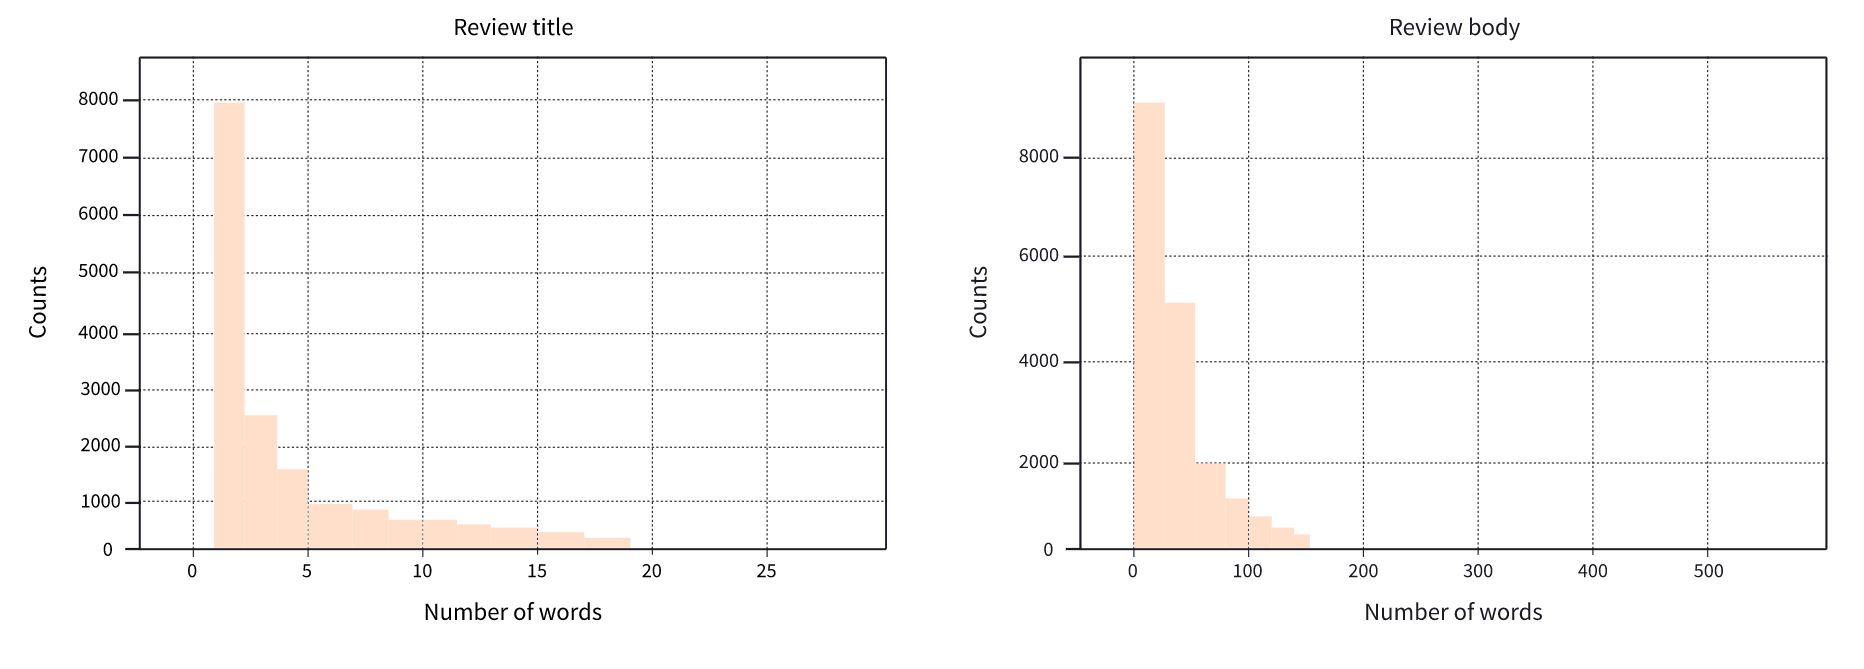

To deal with this, we’ll filter out the examples with very short titles so that our model can produce more interesting summaries. Since we’re dealing with English and Spanish texts, we can use a rough heuristic to split the titles on whitespace and then use our trusty Dataset.filter() method as follows:

In [10]:
books_dataset = books_dataset.filter(lambda x: len(x["review_title"].split()) > 2)

  0%|          | 0/18 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

# Models for text summarization

If you think about it, text summarization is a similar sort of task to machine translation: we have a body of text like a review that we’d like to “translate” into a shorter version that captures the salient features of the input. Accordingly, most Transformer models for summarization adopt the encoder-decoder architecture , although there are some exceptions like the GPT family of models which can also be used for summarization in few-shot settings. The following table lists some popular pretrained models that can be fine-tuned for summarization.
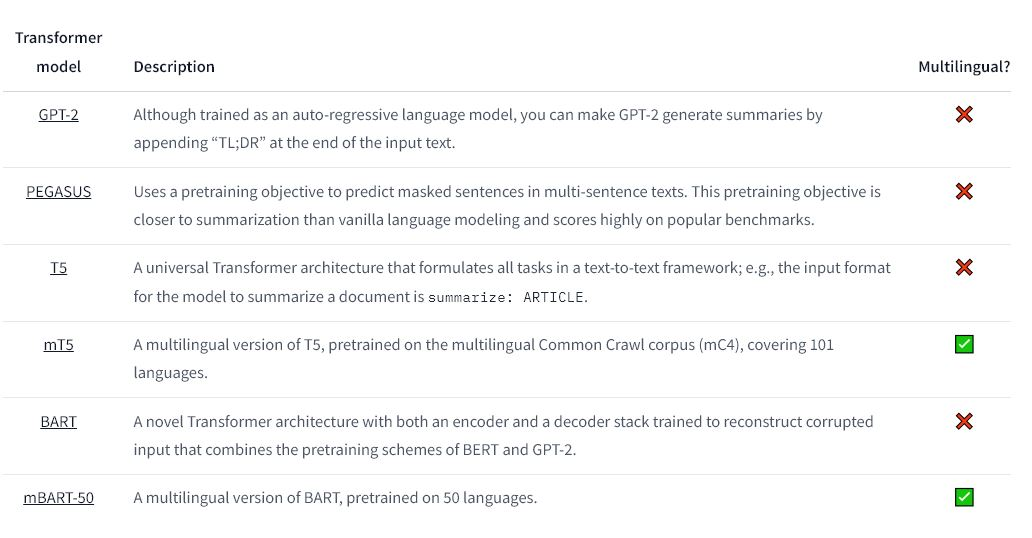

As you can see from this table, the majority of Transformer models for summarization (and indeed most NLP tasks) are monolingual. This is great if your task is in a “high-resource” language like English or German, but less so for the thousands of other languages in use across the world. Fortunately, there is a class of multilingual Transformer models, like **mT5** and **mBART**, that come to the rescue. These models are pretrained using language modeling, but with a twist: instead of training on a corpus of one language, they are trained jointly on texts in over 50 languages at once!<br>

We’ll focus on **mT5**, an interesting architecture based on **T5** that was pretrained in a text-to-text framework. In **T5**, every NLP task is formulated in terms of a prompt prefix like summarize: which conditions the model to adapt the generated text to the prompt. As shown in the figure below, this makes T5 extremely versatile, as you can solve many tasks with a single model!<br>

mT5 doesn’t use prefixes, but shares much of the versatility of T5 and has the advantage of being multilingual. Now that we’ve picked a model, let’s take a look at preparing our data for training.<br>




Our next task is to tokenize and encode our reviews and their titles. As usual, we begin by loading the tokenizer associated with the pretrained model checkpoint. We’ll use mt5-small as our checkpoint so we can fine-tune the model in a reasonable amount of time:

In [11]:
from transformers import AutoTokenizer

model_checkpoint = "google/mt5-small"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/553 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/transformers/convert_slow_tokenizer.py:446: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


💡 In the early stages of your NLP projects, a good practice is to train a class of “small” models on a small sample of data. This allows you to debug and iterate faster toward an end-to-end workflow. Once you are confident in the results, you can always scale up the model by simply changing the model checkpoint!

Let’s test out the mT5 tokenizer on a small example:

In [12]:
inputs = tokenizer("I loved reading the Hunger Games!")
inputs

{'input_ids': [336, 259, 28387, 11807, 287, 62893, 295, 12507, 309, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [13]:
tokenizer.convert_ids_to_tokens(inputs.input_ids)

['▁I', '▁', 'loved', '▁reading', '▁the', '▁Hung', 'er', '▁Games', '!', '</s>']

The special Unicode character ▁ and end-of-sequence token </s> indicate that we’re dealing with the SentencePiece tokenizer, which is based on the Unigram segmentation algorithm . Unigram is especially useful for multilingual corpora since it allows SentencePiece to be agnostic about accents, punctuation, and the fact that many languages, like Japanese, do not have whitespace characters.
<br>
<Br>
To tokenize our corpus, we have to deal with a subtlety associated with summarization: because our labels are also text, it is possible that they exceed the model’s maximum context size. This means we need to apply truncation to both the reviews and their titles to ensure we don’t pass excessively long inputs to our model. The tokenizers in 🤗 Transformers provide a nifty text_target argument that allows you to tokenize the labels in parallel to the inputs. Here is an example of how the inputs and targets are processed for mT5:

In [36]:
max_input_length = 512
max_target_length = 30


def preprocess_function(examples):
    model_inputs = tokenizer(
        examples["review_body"],
        max_length=max_input_length,
        truncation=True,
    )
    labels = tokenizer(
        examples["review_title"], max_length=max_target_length, truncation=True
    )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

Let’s walk through this code to understand what’s happening. The first thing we’ve done is define values for max_input_length and max_target_length, which set the upper limits for how long our reviews and titles can be. Since the review body is typically much larger than the title, we’ve scaled these values accordingly.
<Br>
With preprocess_function(), it is then a simple matter to tokenize the whole corpus using the handy Dataset.map() function we’ve used extensively throughout this course:

In [37]:
tokenized_datasets = books_dataset.map(preprocess_function, batched=True)

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Now that the corpus has been preprocessed, let’s take a look at some metrics that are commonly used for summarization. As we’ll see, there is no silver bullet when it comes to measuring the quality of machine-generated text.

In [20]:
generated_summary = "I absolutely loved reading the Hunger Games"
reference_summary = "I loved reading the Hunger Games"

Measuring the performance of text generation tasks like summarization or translation is not as straightforward. For example, given a review like “I loved reading the Hunger Games”, there are multiple valid summaries, like “I loved the Hunger Games” or “Hunger Games is a great read”. Clearly, applying some sort of exact match between the generated summary and the label is not a good solution — even humans would fare poorly under such a metric, because we all have our own writing style.

For summarization, one of the most commonly used metrics is the **ROUGE score** (short for Recall-Oriented Understudy for Gisting Evaluation). The basic idea behind this metric is to compare a generated summary against a set of reference summaries that are typically created by humans. To make this more precise, suppose we want to compare the following two summaries:

One way to compare them could be to count the number of overlapping words, which in this case would be 6. However, this is a bit crude, so instead ROUGE is based on computing the precision and recall scores for the overlap.

In [21]:
!pip install rouge_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24955 sha256=fe10c0448b298b9187e49d4ab2cd4546744e23b8295804fd93f5ae47f60e8d6c
  Stored in directory: /root/.cache/pip/wheels/24/55/6f/ebfc4cb176d1c9665da4e306e1705496206d08215c1acd9dde
Successfully built rouge-score


In [22]:
import evaluate

rouge_score = evaluate.load("rouge")

In [23]:
scores = rouge_score.compute(
    predictions=[generated_summary], references=[reference_summary]
)
scores

{'rouge1': 0.923076923076923,
 'rouge2': 0.7272727272727272,
 'rougeL': 0.923076923076923,
 'rougeLsum': 0.923076923076923}

Great, the precision and recall numbers match up! Now what about those other ROUGE scores? `rouge2` measures the overlap between bigrams (think the overlap of pairs of words), while `rougeL` and `rougeLsum` measure the longest matching sequences of words by looking for the longest common substrings in the generated and reference summaries. The “sum” in `rougeLsum` refers to the fact that this metric is computed over a whole summary, while rougeL is computed as the average over individual sentences.

## Creating a strong baseline

We’ll use these ROUGE scores to track the performance of our model, but before doing that let’s do something every good NLP practitioner should do: create a strong, yet simple baseline!

A common baseline for text summarization is to simply take the first three sentences of an article, often called the lead-3 baseline. We could use full stops to track the sentence boundaries, but this will fail on acronyms like “U.S.” or “U.N.” — so instead we’ll use the nltk library, which includes a better algorithm to handle these cases. You can install the package using pip as follows:

In [25]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
import nltk

nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Next, we import the sentence tokenizer from nltk and create a simple function to extract the first three sentences in a review. The convention in text summarization is to separate each summary with a newline, so let’s also include this and test it on a training example:

In [27]:
from nltk.tokenize import sent_tokenize


def three_sentence_summary(text):
    return "\n".join(sent_tokenize(text)[:3])


print(three_sentence_summary(books_dataset["train"][1]["review_body"]))

I grew up reading Koontz, and years ago, I stopped,convinced i had "outgrown" him.
Still,when a friend was looking for something suspenseful too read, I suggested Koontz.
She found Strangers.


This seems to work, so let’s now implement a function that extracts these “summaries” from a dataset and computes the ROUGE scores for the baseline:

In [29]:
def evaluate_baseline(dataset, metric):
    summaries = [three_sentence_summary(text) for text in dataset["review_body"]]
    return metric.compute(predictions=summaries, references=dataset["review_title"])

We can then use this function to compute the ROUGE scores over the validation set and prettify them a bit using Pandas:

In [31]:
import pandas as pd

score = evaluate_baseline(books_dataset["validation"], rouge_score)
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, round(score[rn] * 100, 2)) for rn in rouge_names)
rouge_dict

{'rouge1': 16.82, 'rouge2': 8.87, 'rougeL': 15.5, 'rougeLsum': 15.96}

We can see that the rouge2 score is significantly lower than the rest; this likely reflects the fact that review titles are typically concise and so the lead-3 baseline is too verbose. Now that we have a good baseline to work from, let’s turn our attention toward fine-tuning mT5!

# Fine-tuning mT5 with Keras

Fine-tuning a model for summarization is very similar to the other tasks we’ve covered in this chapter. The first thing we need to do is load the pretrained model from the mt5-small checkpoint. Since summarization is a sequence-to-sequence task, we can load the model with the TFAutoModelForSeq2SeqLM class, which will automatically download and cache the weights:

In [32]:
from transformers import TFAutoModelForSeq2SeqLM

model = TFAutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFMT5ForConditionalGeneration.

All the layers of TFMT5ForConditionalGeneration were initialized from the model checkpoint at google/mt5-small.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFMT5ForConditionalGeneration for predictions without further training.


Next, we need to define a data collator for our sequence-to-sequence task. Since mT5 is an encoder-decoder Transformer model, one subtlety with preparing our batches is that during decoding we need to shift the labels to the right by one. This is required to ensure that the decoder only sees the previous ground truth labels and not the current or future ones, which would be easy for the model to memorize.

Luckily, 🤗 Transformers provides a `DataCollatorForSeq2Seq` collator that will dynamically pad the inputs and the labels for us. To instantiate this collator, we simply need to provide the tokenizer and model:



In [33]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="tf")

Let’s see what this collator produces when fed a small batch of examples. First, we need to remove the columns with strings because the collator won’t know how to pad these elements:

In [38]:
tokenized_datasets = tokenized_datasets.remove_columns(
    books_dataset["train"].column_names
)

Since the collator expects a list of dicts, where each dict represents a single example in the dataset, we also need to wrangle the data into the expected format before passing it to the data collator:

In [39]:
features = [tokenized_datasets["train"][i] for i in range(2)]
data_collator(features)

{'input_ids': <tf.Tensor: shape=(2, 188), dtype=int32, numpy=
array([[   653,   1957,   1314,    261,   2757,   1280,    435,    259,
         29166,    263,    269,    774,   5547,      1,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
  

The main thing to notice here is that the first example is longer than the second one, so the input_ids and attention_mask of the second example have been padded on the right with a [PAD] token (whose ID is 0). Similarly, we can see that the labels have been padded with -100s, to make sure the padding tokens are ignored by the loss function. And finally, we can see a new decoder_input_ids which has shifted the labels to the right by inserting a [PAD] token in the first entry.

We’re almost ready to train! We just need to convert our datasets to tf.data.Datasets using the data collator we defined above, and then compile() and fit() the model. First, the datasets:

In [40]:
tf_train_dataset = tokenized_datasets["train"].to_tf_dataset(
    columns=["input_ids", "attention_mask", "labels"],
    collate_fn=data_collator,
    shuffle=True,
    batch_size=8,
)
tf_eval_dataset = tokenized_datasets["validation"].to_tf_dataset(
    columns=["input_ids", "attention_mask", "labels"],
    collate_fn=data_collator,
    shuffle=False,
    batch_size=8,
)

**Now, we define our training hyperparameters and compile:**

In [41]:
from transformers import create_optimizer
import tensorflow as tf

# The number of training steps is the number of samples in the dataset, divided by the batch size then multiplied
# by the total number of epochs. Note that the tf_train_dataset here is a batched tf.data.Dataset,
# not the original Hugging Face Dataset, so its len() is already num_samples // batch_size.
num_train_epochs = 8
num_train_steps = len(tf_train_dataset) * num_train_epochs
model_name = model_checkpoint.split("/")[-1]

optimizer, schedule = create_optimizer(
    init_lr=5.6e-5,
    num_warmup_steps=0,
    num_train_steps=num_train_steps,
    weight_decay_rate=0.01,
)

model.compile(optimizer=optimizer)

# Train in mixed-precision float16
tf.keras.mixed_precision.set_global_policy("mixed_float16")

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [47]:
from transformers.keras_callbacks import PushToHubCallback

callback = PushToHubCallback(
    output_dir=f"{model_name}-finetuned-amazon-en-es", tokenizer=tokenizer
)

model.fit(
    tf_train_dataset, validation_data=tf_eval_dataset, callbacks=[callback], epochs=8
)

Epoch 1/8
1209/1209 [==============================] - 360s 298ms/step - loss: 4.8750 - val_loss: 3.4999
Epoch 2/8
1209/1209 [==============================] - 360s 297ms/step - loss: 4.5371 - val_loss: 3.4354
Epoch 3/8
1209/1209 [==============================] - 358s 297ms/step - loss: 4.3195 - val_loss: 3.3777
Epoch 4/8
1209/1209 [==============================] - 362s 300ms/step - loss: 4.1651 - val_loss: 3.3484
Epoch 5/8
1209/1209 [==============================] - 350s 290ms/step - loss: 4.0543 - val_loss: 3.3300
Epoch 6/8
1209/1209 [==============================] - 348s 287ms/step - loss: 4.0197 - val_loss: 3.3286
Epoch 7/8
1209/1209 [==============================] - 361s 299ms/step - loss: 4.0279 - val_loss: 3.3286
Epoch 8/8
1209/1209 [==============================] - 353s 292ms/step - loss: 4.0182 - val_loss: 3.3286


We got some loss values during training, but really we’d like to see the ROUGE metrics we computed earlier. To get those metrics, we’ll need to generate outputs from the model and convert them to strings. Let’s build some lists of labels and predictions for the ROUGE metric to compare

In [58]:
from tqdm import tqdm
import numpy as np

generation_data_collator = DataCollatorForSeq2Seq(
    tokenizer, model=model, return_tensors="tf", pad_to_multiple_of=320
)

tf_generate_dataset = model.prepare_tf_dataset(
    tokenized_datasets["validation"],
    collate_fn=generation_data_collator,
    shuffle=False,
    batch_size=8,
    drop_remainder=True,
)



def generate_with_xla(batch):
    return model.generate(
        input_ids=batch["input_ids"],
        attention_mask=batch["attention_mask"],
        max_new_tokens=32,
    )


all_preds = []
all_labels = []
for batch, labels in tqdm(tf_generate_dataset):
    predictions = generate_with_xla(batch)
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = labels.numpy()
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    decoded_preds = ["\n".join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(sent_tokenize(label.strip())) for label in decoded_labels]
    all_preds.extend(decoded_preds)
    all_labels.extend(decoded_labels)

100%|██████████| 29/29 [01:19<00:00,  2.75s/it]


In [74]:
result = rouge_score.compute(
    predictions=decoded_preds, references=decoded_labels, use_stemmer=True
)
result = {key: value * 100 for key, value in result.items()}
{k: round(v, 4) for k, v in result.items()}


{'rouge1': 5.3571, 'rouge2': 0.0, 'rougeL': 5.3571, 'rougeLsum': 5.3571}

# Using your fine-tuned model

Once you’ve pushed the model to the Hub, you can play with it either via the inference widget or with a pipeline object, as follows:

In [68]:
from transformers import pipeline

hub_model_id = "huggingface-course/mt5-small-finetuned-amazon-en-es"
summarizer = pipeline("summarization", model=hub_model_id)

Downloading:   0%|          | 0.00/682 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/398 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.33M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

We can feed some examples from the test set (which the model has not seen) to our pipeline to get a feel for the quality of the summaries. First let’s implement a simple function to show the review, title, and generated summary together:

In [69]:
def print_summary(idx):
    review = books_dataset["test"][idx]["review_body"]
    title = books_dataset["test"][idx]["review_title"]
    summary = summarizer(books_dataset["test"][idx]["review_body"])[0]["summary_text"]
    print(f"'>>> Review: {review}'")
    print(f"\n'>>> Title: {title}'")
    print(f"\n'>>> Summary: {summary}'")

In [71]:
print_summary(50)

'>>> Review: Overall this is an amazing book! Only lost one star due to poor packaging, but besides a few bent and out of place pages this was great!'

'>>> Title: Good product, needs better packaging'

'>>> Summary: Overall this is an amazing book! Only lost one star due to poor packaging'


This is not too bad! We can see that our model has actually been able to perform abstractive summarization by augmenting parts of the review with new words. And perhaps the coolest aspect of our model is that it is bilingual, so we can also generate summaries of Spanish reviews:

In [72]:
print_summary(100)

Your max_length is set to 20, but you input_length is only 9. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


'>>> Review: Muy apropiado para mis hijas'

'>>> Title: Libros para el verano'

'>>> Summary: Muy buen libro'
